## MODELOS ARIMA & LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN SECTOR RESIDENCIAL EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

Importamos las librerias necesarias

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Importamos la data de Demanda de gas en sector residencial como un CSV

Se lee la data "original" de Demanda en sector residencial

In [102]:
demanda_residencial_original = pd.read_csv('Demanda_residencial_2023.csv',index_col='Date',parse_dates=True)
demanda_residencial_original

,Demanded_Gas
Date,
2005-01-01,152.096
2005-02-01,159.992
2005-03-01,114.877
2005-04-01,97.182
2005-05-01,89.744
...,...
2023-05-01,92.484
2023-06-01,90.629
2023-07-01,95.059


Se grafica la data "original" de Demanda en sector residencial

Text(0, 0.5, 'Demanda [MMpcd]')

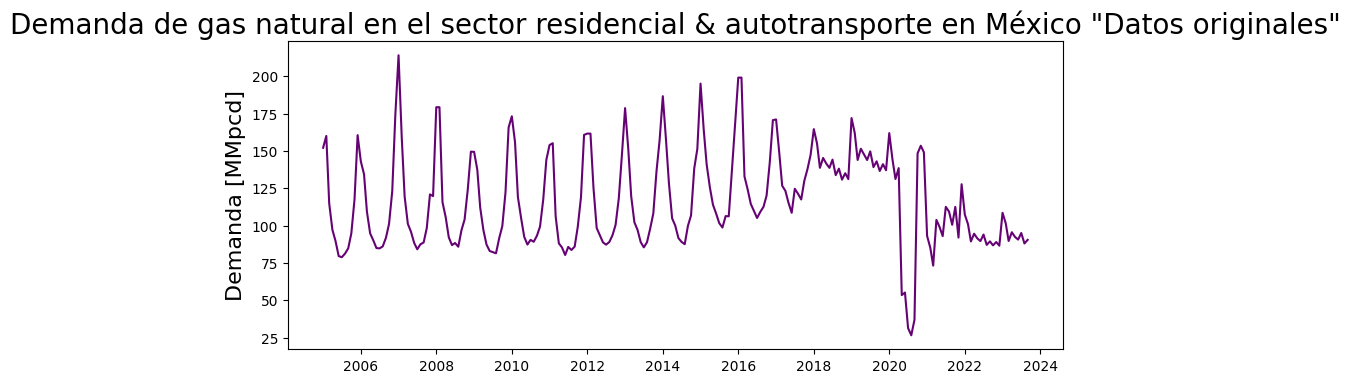

In [103]:
plt.figure(figsize=(10,4))
plt.plot(demanda_residencial_original, color='#660374')
plt.title('Demanda de gas natural en el sector residencial & autotransporte en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda en sector residencial en sus compoentes de Tendencia, Estacionalidad y Residual

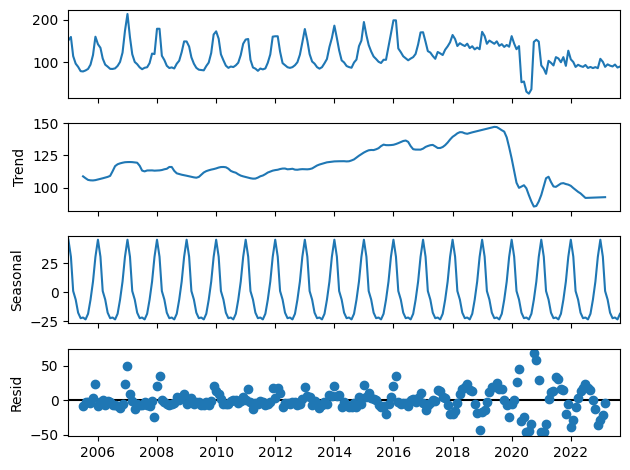

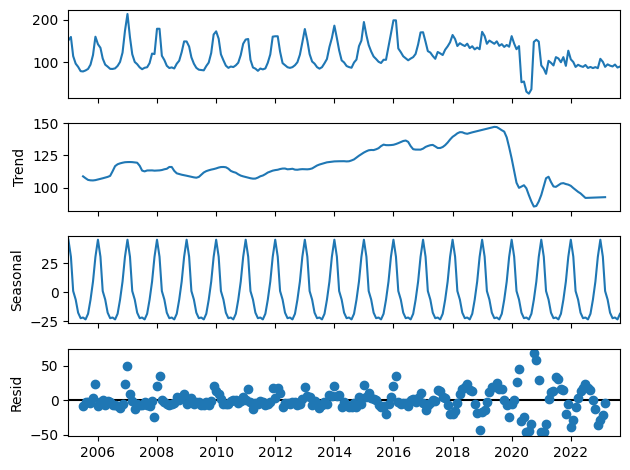

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_residencial_original_seasonal_decomposition = seasonal_decompose(demanda_residencial_original)
demanda_residencial_original_seasonal_decomposition.plot()

Separamos la data original de Demanda de gas natural en el sector residencial en data de train y test

In [105]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_residencial_original_train_data = demanda_residencial_original[:-num_test_points]
demanda_residencial_original_test_data = demanda_residencial_original[-num_test_points:]
demanda_residencial_original_train_data

,Demanded_Gas
Date,
2005-01-01,152.096
2005-02-01,159.992
2005-03-01,114.877
2005-04-01,97.182
2005-05-01,89.744
...,...
2022-05-01,91.528
2022-06-01,89.620
2022-07-01,94.010


Se grafica la distribución de los datos "originales" de train de Demanda en sector residencial

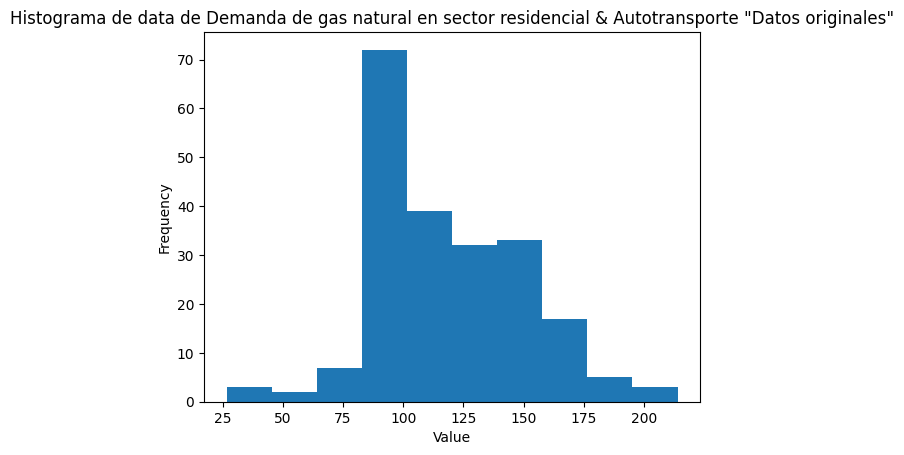

In [106]:
# Generate the histogram
plt.hist(demanda_residencial_original_train_data, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector residencial & Autotransporte "Datos originales"')

# Display the plot
plt.show()

In [107]:
demanda_residencial_original_train_data.describe()

,Demanded_Gas
count,213.000000
mean,117.984826
std,31.861548
min,26.607000
25%,92.190000
50%,112.550000
75%,142.440000
max,213.995000


In [108]:
mean_demanda_residencial_original_train_data =  demanda_residencial_original_train_data.describe().values[1]
mean_demanda_residencial_original_train_data

array([117.98482629])

In [109]:
st_demanda_residencial_original_train_data =  demanda_residencial_original_train_data.describe().values[2]
st_demanda_residencial_original_train_data

array([31.86154793])

In [110]:
mean_demanda_residencial_original_train_data / st_demanda_residencial_original_train_data

array([3.70304753])

Se lleva a cabo una prueba de normalidad a los datos "originales" de train de Demanda en sector residencial & autotrasnporte

In [111]:
import scipy.stats as stats

# Assuming demanda_residencial_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_residencial_original_train_data

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 3.108615593358281
p-value: 0.21133561923985608


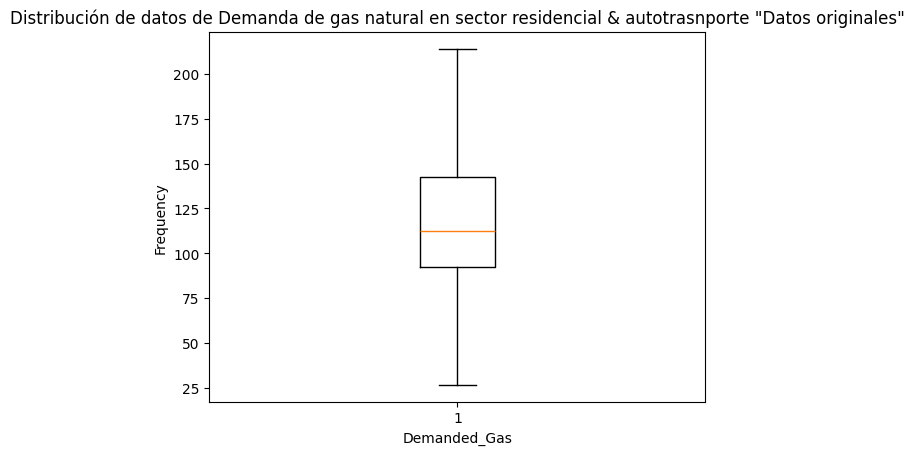

In [112]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_residencial_original_train_data)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector residencial & autotrasnporte "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [113]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [114]:
demanda_residencial_original_train_data["Demanded_Gas"]

Date
2005-01-01    152.096
2005-02-01    159.992
2005-03-01    114.877
2005-04-01     97.182
2005-05-01     89.744
               ...   
2022-05-01     91.528
2022-06-01     89.620
2022-07-01     94.010
2022-08-01     87.092
2022-09-01     89.456
Name: Demanded_Gas, Length: 213, dtype: float64

In [115]:
n_input = 24

data = demanda_residencial_original_train_data["Demanded_Gas"]
targets = data 


demanda_residencial_original_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [116]:
print("Total number of samples in the original training data = ", len(demanda_residencial_original_train_data)) 
print("Total number of samples in the demanda_residencial_train_generator = ", len(demanda_residencial_original_train_generator))


Total number of samples in the original training data =  213
Total number of samples in the demanda_residencial_train_generator =  189


In [117]:
demanda_residencial_original_train_generator[200]

(array([], dtype=float64), array([], dtype=float64))

### Se define y entrena la red neuronal FNN  para el caso de la data original de Demanda en el sector residencial 

In [118]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [119]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

Se define la red neuronal FFNN con capas densas y funcion de activación tipo RELU.

In [120]:
n_input = n_input 
n_features = 1

# define model
model_FF_residencial_sin_tratamiento = Sequential()
model_FF_residencial_sin_tratamiento.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_FF_residencial_sin_tratamiento.add(Dense(32, activation='relu'))
model_FF_residencial_sin_tratamiento.add(Dense(1))
model_FF_residencial_sin_tratamiento.compile(optimizer='Adam', loss='mse')

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [121]:
model_FF_residencial_sin_tratamiento.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 24, 64)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 24, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
model_FF_residencial_sin_tratamiento.fit(demanda_residencial_original_train_generator, epochs=12)

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


Epoch 1/12
 51/189 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12054.4658

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7037.7246
Epoch 2/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1759.0757
Epoch 3/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1836.5039
Epoch 4/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1908.2570
Epoch 5/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1686.7734
Epoch 6/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1448.1647
Epoch 7/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1657.1813
Epoch 8/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1522.7509
Epoch 9/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2002.5662
Epoch 10/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1866.7693
Epoch 11/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1787.4805
Epoch 12/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1614.0054


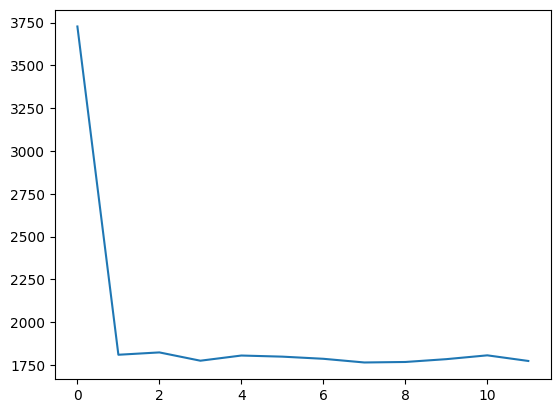

In [123]:
loss_per_epoch_model_FF = model_FF_residencial_sin_tratamiento.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [124]:
n_input = n_input
n_features = n_features

In [125]:
test_predictions_model_FF_residencial_sin_pretratamiento = []

first_eval_batch = demanda_residencial_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_residencial_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_FF_residencial_sin_tratamiento.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_FF_residencial_sin_pretratamiento.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [126]:
test_predictions_model_FF_residencial_sin_pretratamiento

[88.57285,
 87.7357,
 86.94215,
 86.189926,
 85.47688,
 84.80099,
 84.16029,
 83.55297,
 82.97728,
 82.431564,
 81.914276,
 81.423935]

Text(0, 0.5, 'Demanda [MMpcd]')

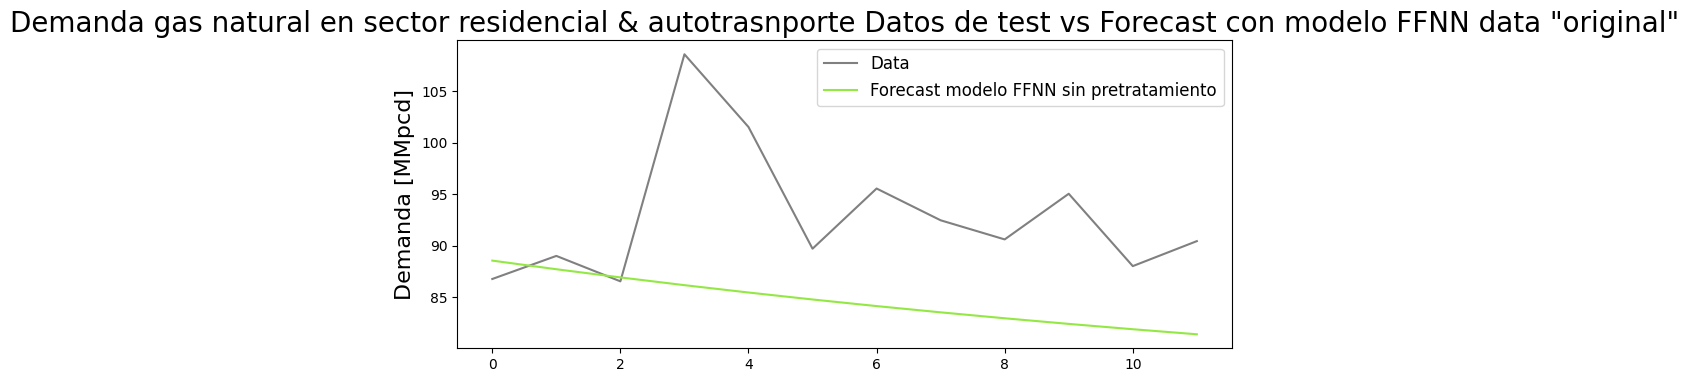

In [127]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_FF_residencial_sin_pretratamiento, color='#94E844')
plt.legend(('Data', 'Forecast modelo FFNN sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector residencial & autotrasnporte Datos de test vs Forecast con modelo FFNN data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda en el sector residencial & autotrasnporte

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [128]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [129]:
n_input = n_input
n_features = n_features

In [130]:


# define model
model_LSTM_residencial_original = Sequential()
model_LSTM_residencial_original.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_residencial_original.add(Dense(1))
model_LSTM_residencial_original.compile(optimizer='adam', loss='mse')

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [131]:
model_LSTM_residencial_original.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo LSTM

In [132]:
model_LSTM_residencial_original.fit(demanda_residencial_original_train_generator, epochs=12)


Epoch 1/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 18155.5020
Epoch 2/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1482.5408
Epoch 3/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1265.2100
Epoch 4/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 980.8325
Epoch 5/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 814.7042
Epoch 6/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1102.1765
Epoch 7/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 822.6230
Epoch 8/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 555.3895
Epoch 9/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 705.2185
Epoch 10/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1079.3790
Epoch 11/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 669.7219
Epoch 12/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 460.2057


Se grafica la perdida por epoch

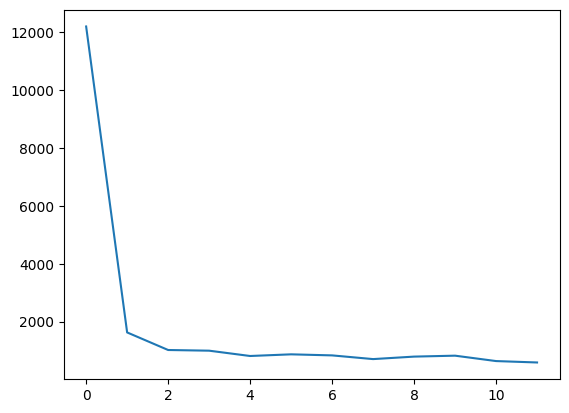

In [133]:
loss_per_epoch_model_FF = model_LSTM_residencial_original.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_residencialindustrial_original previamente definido y entrenado

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [134]:
n_input = n_input
n_features = n_features

In [135]:
test_predictions_model_LSTM_residencial_original = []

first_eval_batch = demanda_residencial_original_train_data[-n_input:]["Demanded_Gas"].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_residencial_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_residencial_original.predict(current_batch)[0]

    print("Current_batch is:")
    print(current_batch)
    print("************************************************************************")
    print("Current_pred is:")
    print(current_pred)
    # append the prediction into the array
    test_predictions_model_LSTM_residencial_original.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Current_batch is:
[[[148.324]
  [153.468]
  [149.084]
  [ 93.077]
  [ 85.229]
  [ 73.218]
  [103.831]
  [ 99.209]
  [ 92.949]
  [112.564]
  [109.434]
  [100.533]
  [112.531]
  [ 91.981]
  [127.691]
  [107.384]
  [100.933]
  [ 89.417]
  [ 94.568]
  [ 91.528]
  [ 89.62 ]
  [ 94.01 ]
  [ 87.092]
  [ 89.456]]]
************************************************************************
Current_pred is:
[122.14651]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Current_batch is:
[[[153.468     ]
  [149.084     ]
  [ 93.077     ]
  [ 85.229     ]
  [ 73.218     ]
  [103.831     ]
  [ 99.209     ]
  [ 92.949     ]
  [112.564     ]
  [109.434     ]
  [100.533     ]
  [112.531     ]
  [ 91.981     ]
  [127.691     ]
  [107.384     ]
  [100.933     ]
  [ 89.417     ]
  [ 94.568     ]
  [ 91.528     ]
  [ 89.62      ]
  [ 94.01      ]
  [ 87.092     ]
  [ 89.456     ]
  [122.14650726]]]
************************************************************************
Current_pred

In [136]:
test_predictions_model_LSTM_residencial_original

[array([122.14651], dtype=float32),
 array([113.91763], dtype=float32),
 array([103.15726], dtype=float32),
 array([93.426414], dtype=float32),
 array([88.52051], dtype=float32),
 array([89.21945], dtype=float32),
 array([90.70393], dtype=float32),
 array([91.435616], dtype=float32),
 array([87.8925], dtype=float32),
 array([94.16007], dtype=float32),
 array([91.51455], dtype=float32),
 array([92.41897], dtype=float32)]

Se grafican los 12 meses de test vs el forecast del modelo LSTM con la data de entrenamiento 

Text(0, 0.5, 'Demanda [MMpcd]')

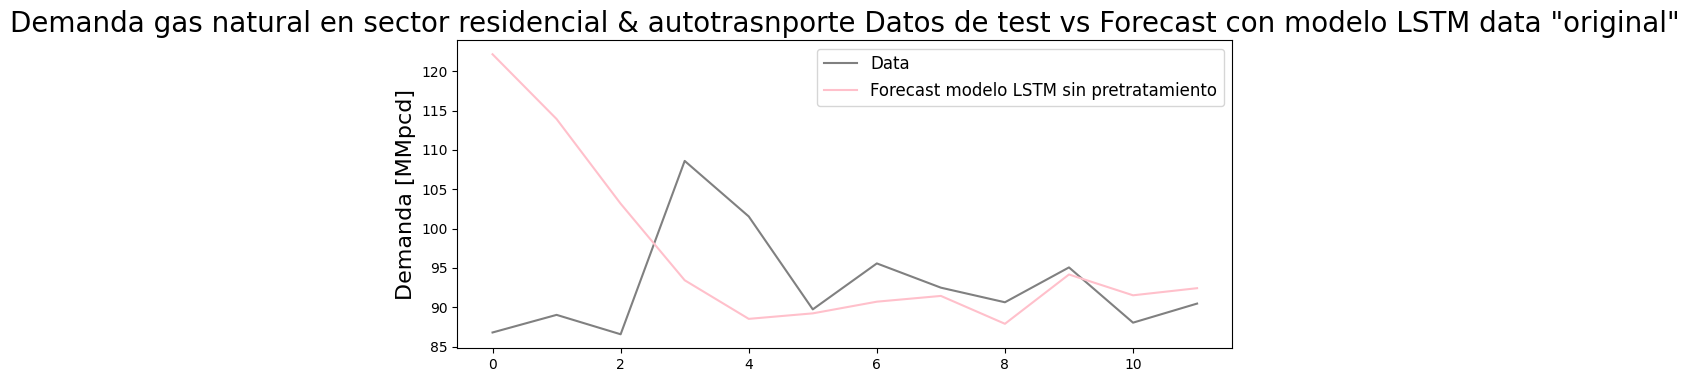

In [137]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_residencial_original, color='pink')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector residencial & autotrasnporte Datos de test vs Forecast con modelo LSTM data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo LSTM sin la data pretratada

In [138]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_residencial_original = mean_absolute_percentage_error(demanda_residencial_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_residencial_original)
RMSE_predictions_model_LSTM_residencial_original = np.sqrt(mean_squared_error(demanda_residencial_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_residencial_original))

print('MAPE:', MAPE_predictions_model_LSTM_residencial_original)
print('RMSE:', RMSE_predictions_model_LSTM_residencial_original)

MAPE: 0.10959989036151226
RMSE: 14.701842278933935


Proceso para decidir el modelo ARIMA a aplicar en el caso de (SIN pretratamiento de atípicos)

Se verifica la estacionariedad de la data original con ayuda de la prueba de Dickey-Fuller

In [139]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_residencial_original_sin_diferenciar = adfuller(demanda_residencial_original)


adf_test_residencial_original_sin_diferenciar

(-1.8289404581239443,
 0.36619113885497423,
 13,
 211,
 {'1%': -3.46172743446274,
  '5%': -2.8753374677799957,
  '10%': -2.574124089081557},
 1761.8933936875399)

In [140]:
print(f"The ADF statistic value f is: {adf_test_residencial_original_sin_diferenciar[0]}")

print(f"The ADF p value p is: {adf_test_residencial_original_sin_diferenciar[1]}")

if adf_test_residencial_original_sin_diferenciar[0] < adf_test_residencial_original_sin_diferenciar[4]['5%']:
    print("Se rechaza H0: SI existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: NO existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -1.8289404581239443
The ADF p value p is: 0.36619113885497423
Se acepta H0: NO existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad


Se procede a hacer la primer diferencia para lograr estacionariedad 

In [141]:
demanda_residencial_original_diff1 = demanda_residencial_original.diff()
demanda_residencial_original_diff1

,Demanded_Gas
Date,
2005-01-01,NaN
2005-02-01,7.896
2005-03-01,-45.115
2005-04-01,-17.695
2005-05-01,-7.438
...,...
2023-05-01,-3.083
2023-06-01,-1.855
2023-07-01,4.430


Se verifica la estacionariedad de la data original CON UNA DIFERENCIA con ayuda de la prueba de Dickey-Fuller

In [142]:

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_residencial_original_con_diferencia = adfuller(demanda_residencial_original_diff1.dropna())


adf_test_residencial_original_con_diferencia

(-6.102050662643757,
 9.782260378133742e-08,
 13,
 210,
 {'1%': -3.461878735881654,
  '5%': -2.875403665910809,
  '10%': -2.574159410430839},
 1755.815320377235)

Se realizan las gráficas ACF & PACF para determinar el tipo de modelo ARIMA a implementar 

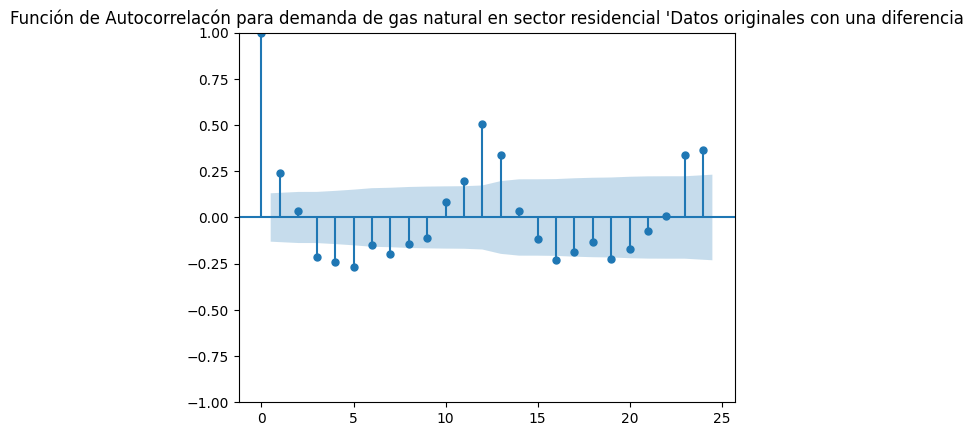

In [143]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_acf(demanda_residencial_original_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón para demanda de gas natural en sector residencial 'Datos originales con una diferencia")

# Show the plot
plt.show()

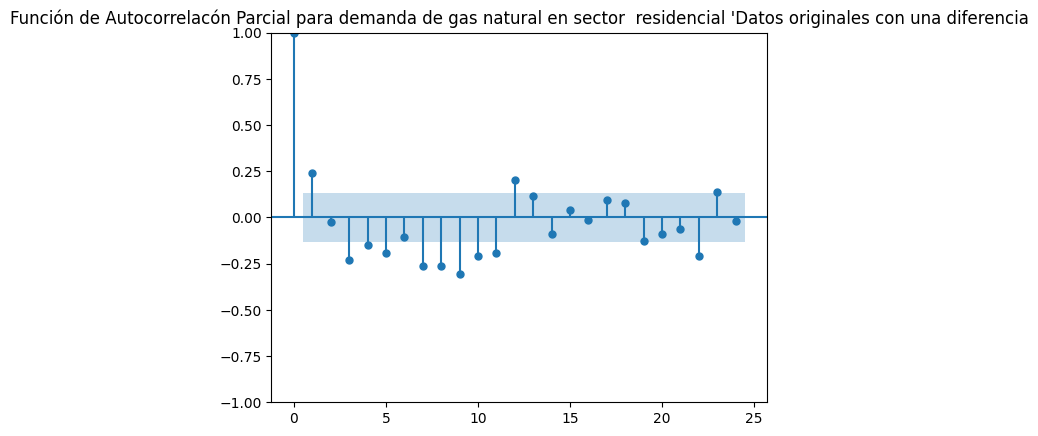

In [144]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_pacf(demanda_residencial_original_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón Parcial para demanda de gas natural en sector  residencial 'Datos originales con una diferencia")

# Show the plot
plt.show()

### Se define y entrena modelo ARIMA para el caso de la data original de Demanda en el sector residencial & autotrasnporte

In [145]:
##Create the model
model_ARIMA_residencial_original = ARIMA (demanda_residencial_original_train_data, order=(4,1,3))

##Fit the model
start = time()
model_ARIMA_residencial_original_fit = model_ARIMA_residencial_original.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_residencial_original_fit.summary())

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\sta

Model fitting time 7.271967887878418
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -905.698
Date:                Wed, 19 Jun 2024   AIC                           1827.395
Time:                        10:33:23   BIC                           1854.248
Sample:                    01-01-2005   HQIC                          1838.248
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7583      0.229      3.309      0.001       0.309       1.207
ar.L2          0.5572      0.269      2.068      0.039       0.029       1.085
ar.L3         -

In [146]:
##get prediction start and end dates 
pred_model_ARIMA_residencial_start_date = demanda_residencial_original_test_data.index[0]
pred_model_ARIMA_residencial_end_date = demanda_residencial_original_test_data.index[-1]

##get the predictors and residuals 
predictions_model_ARIMA_residencial_original = model_ARIMA_residencial_original_fit.predict(start=pred_model_ARIMA_residencial_start_date, end= pred_model_ARIMA_residencial_end_date)
predictions_model_ARIMA_residencial_original


2022-10-01     98.338440
2022-11-01    103.118906
2022-12-01    107.477760
2023-01-01    106.228326
2023-02-01    104.186190
2023-03-01     98.571307
2023-04-01     94.413981
2023-05-01     89.759096
2023-06-01     88.449890
2023-07-01     88.027848
2023-08-01     90.622494
2023-09-01     93.214190
Freq: MS, Name: predicted_mean, dtype: float64

In [147]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_residencial_original = mean_absolute_percentage_error(demanda_residencial_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_residencial_original)
RMSE_predictions_model_ARIMA_residencial_original = np.sqrt(mean_squared_error(demanda_residencial_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_residencial_original))

print('MAPE:', MAPE_predictions_model_ARIMA_residencial_original)
print('RMSE:', RMSE_predictions_model_ARIMA_residencial_original)

MAPE: 0.07322972494549211
RMSE: 8.83876552850229


Text(0, 0.5, 'Demanda [MMpcd]')

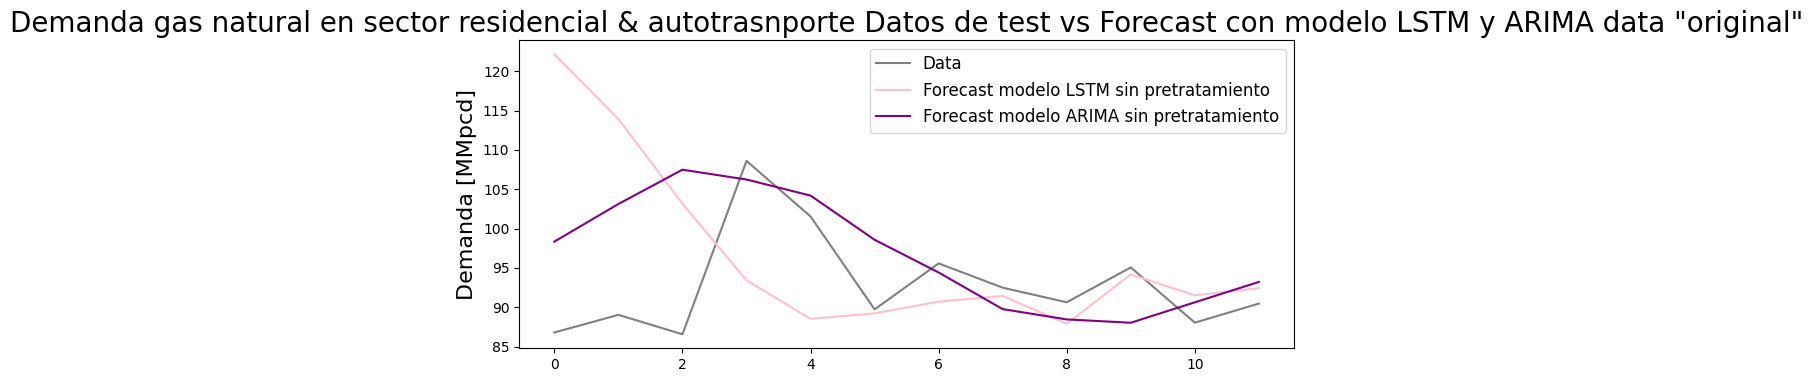

In [148]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_residencial_original, color='pink')
plt.plot(predictions_model_ARIMA_residencial_original.values, color='purple')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento', 'Forecast modelo ARIMA sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector residencial & autotrasnporte Datos de test vs Forecast con modelo LSTM y ARIMA data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [149]:
outlier_threshold = 1.25

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_residencial_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [150]:
demanda_residencial_original_train_para_tratamiento =demanda_residencial_original_train_data.copy()
demanda_residencial_original_train_para_tratamiento

,Demanded_Gas
Date,
2005-01-01,152.096
2005-02-01,159.992
2005-03-01,114.877
2005-04-01,97.182
2005-05-01,89.744
...,...
2022-05-01,91.528
2022-06-01,89.620
2022-07-01,94.010


In [151]:
demanda_residencial_train_pretratamiento_media = remove_replace_outliers_media(demanda_residencial_original_train_para_tratamiento['Demanded_Gas'])
demanda_residencial_train_pretratamiento_media

Date
2005-01-01    152.096
2005-02-01    159.992
2005-03-01    114.877
2005-04-01     97.182
2005-05-01     89.744
               ...   
2022-05-01     91.528
2022-06-01     89.620
2022-07-01     94.010
2022-08-01     87.092
2022-09-01     89.456
Name: Demanded_Gas, Length: 213, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

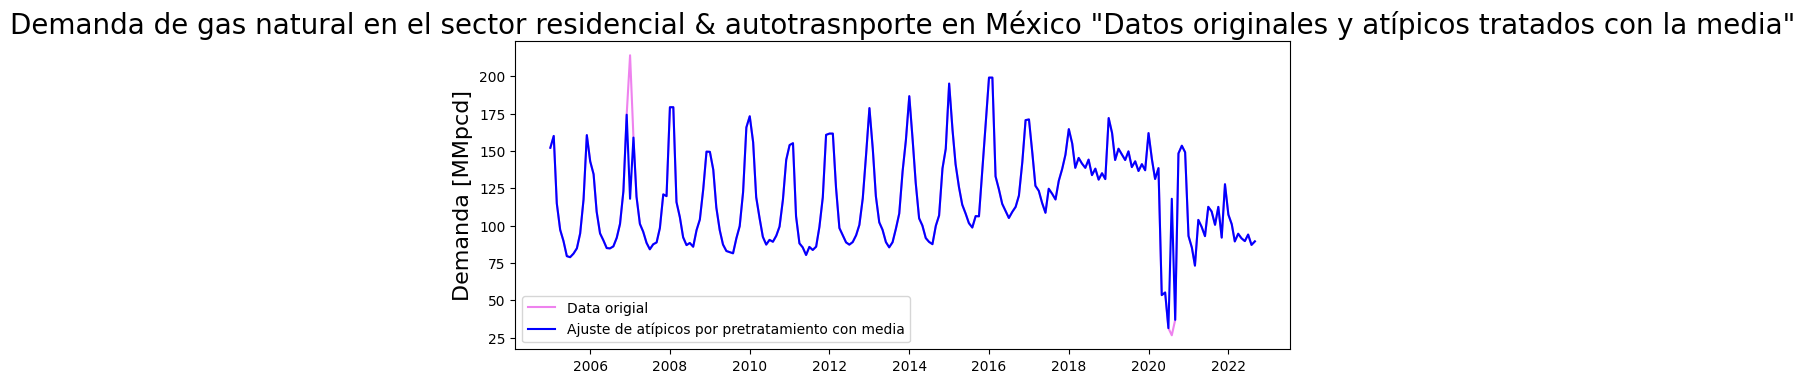

In [152]:
plt.figure(figsize=(10,4))
plt.plot(demanda_residencial_original_train_data, color='violet')
plt.plot(demanda_residencial_train_pretratamiento_media,color='blue')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector residencial & autotrasnporte en México "Datos originales y atípicos tratados con la media"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

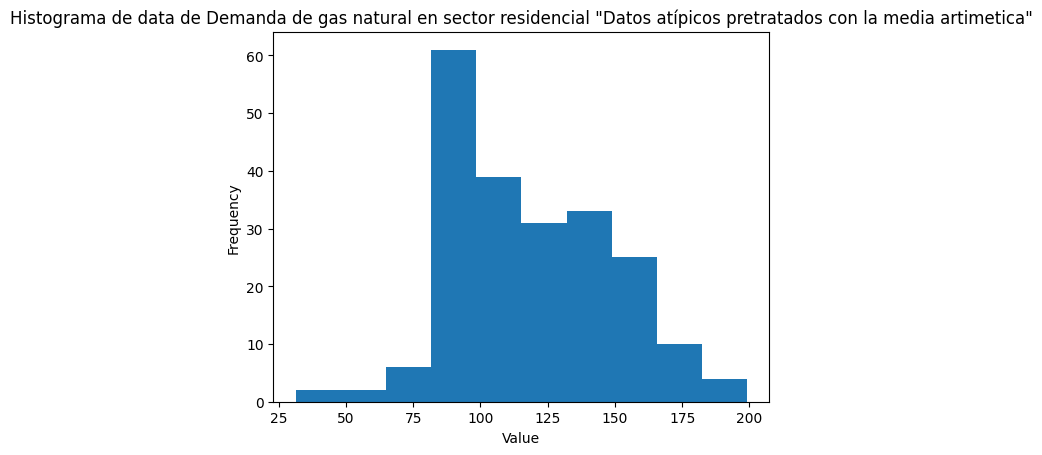

In [153]:
# Generate the histogram
plt.hist(demanda_residencial_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector residencial "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

In [154]:
demanda_residencial_train_pretratamiento_media.describe()

count    213.000000
mean     117.962872
std       30.533432
min       31.412000
25%       92.487000
50%      112.564000
75%      141.576000
max      199.052000
Name: Demanded_Gas, dtype: float64

Evaluación de la dispersión de los datos mediante el cociente de media / desviación estandar

In [155]:

mean_demanda_residencial_train_pretratamiento_media = demanda_residencial_train_pretratamiento_media.describe().values[1]
mean_demanda_residencial_train_pretratamiento_media

117.9628720379147

In [156]:
std_demanda_residencial_train_pretratamiento_media = demanda_residencial_train_pretratamiento_media.describe().values[2]
std_demanda_residencial_train_pretratamiento_media

30.53343233256438

In [157]:
mean_demanda_residencial_train_pretratamiento_media / std_demanda_residencial_train_pretratamiento_media

3.863400313239775

Recordando el valor del cociente para el caso de no tratamiento de atípicos

In [158]:
mean_demanda_residencial_original_train_data / st_demanda_residencial_original_train_data

array([3.70304753])

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda en sector eléctrico para el caso de pretratamiento con la media artimetica

In [159]:
import scipy.stats as stats

# Assuming demanda_residencial_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_residencial_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 4.236246883727618
p-value: 0.12025708631671768


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

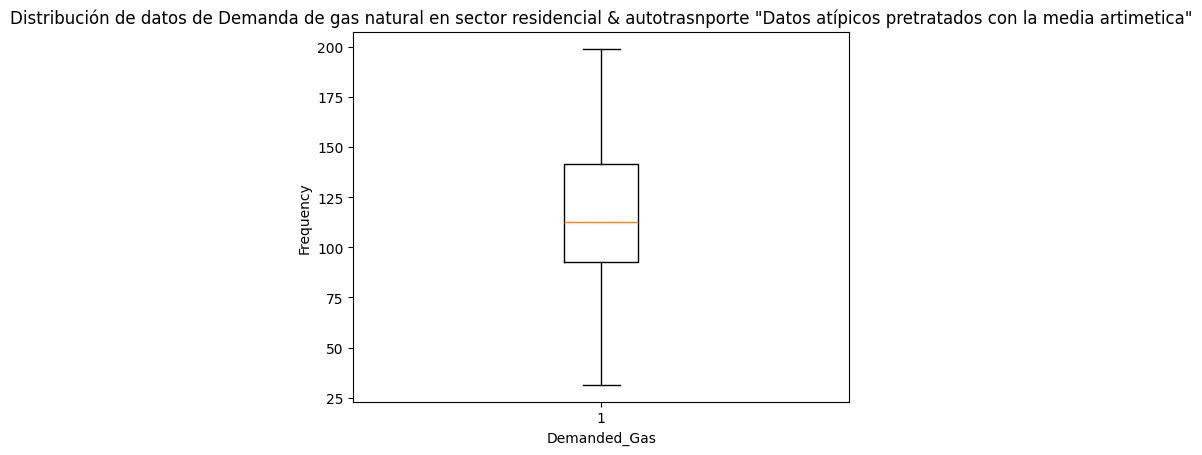

In [160]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_residencial_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector residencial & autotrasnporte "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [161]:
n_input = n_input

data = demanda_residencial_train_pretratamiento_media
targets = data 

demanda_residencial_train_generator_pretratamiento_media = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [162]:
demanda_residencial_train_generator_pretratamiento_media[0]

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[152.096, 159.992, 114.877,  97.182,  89.744,  79.576,  78.868,
          81.248,  84.803,  94.76 , 117.495, 160.554, 142.983, 134.402,
         109.338,  94.816,  90.252,  84.982,  84.755,  86.098,  91.856,
         101.146, 123.065, 174.222]]),
 array([117.96287204]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [163]:
print("Total number of samples in the original training data = ", len(demanda_residencial_train_pretratamiento_media)) 
print("Total number of samples in the demanda_residencial_train_generator = ", len(demanda_residencial_train_generator_pretratamiento_media))

Total number of samples in the original training data =  213
Total number of samples in the demanda_residencial_train_generator =  189


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU.  

In [164]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)



In [165]:
n_input = n_input
n_features = n_features

# define model
model_LSTM_residencial_pretratamiento_media = Sequential()
model_LSTM_residencial_pretratamiento_media.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_residencial_pretratamiento_media.add(Dense(1))
model_LSTM_residencial_pretratamiento_media.compile(optimizer='adam', loss='mse')

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [166]:
model_LSTM_residencial_pretratamiento_media.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_residencial_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [167]:
model_LSTM_residencial_pretratamiento_media.fit(demanda_residencial_train_generator_pretratamiento_media, epochs=12)

Epoch 1/12
 25/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 38595.2891

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 12629.2666
Epoch 2/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 831.6230
Epoch 3/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 812.9260
Epoch 4/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 629.1315
Epoch 5/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 408.5985
Epoch 6/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 453.0870
Epoch 7/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 784.3187
Epoch 8/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 526.1833
Epoch 9/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 675.5511
Epoch 10/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 535.7079
Epoch 11/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 99423.5547
Epoch 12/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1482.9399


Se grafica la perdida por epoch 

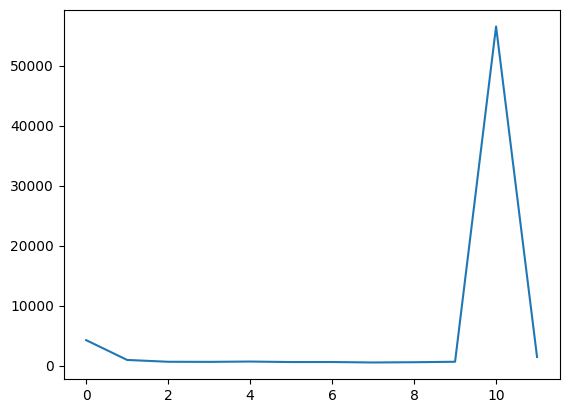

In [168]:
loss_per_epoch = model_LSTM_residencial_pretratamiento_media.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo LSTM previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [169]:
demanda_residencial_train_batch_pretratamiento_media = demanda_residencial_train_pretratamiento_media[-n_input:]


demanda_residencial_train_batch_pretratamiento_media

Date
2020-10-01    148.324
2020-11-01    153.468
2020-12-01    149.084
2021-01-01     93.077
2021-02-01     85.229
2021-03-01     73.218
2021-04-01    103.831
2021-05-01     99.209
2021-06-01     92.949
2021-07-01    112.564
2021-08-01    109.434
2021-09-01    100.533
2021-10-01    112.531
2021-11-01     91.981
2021-12-01    127.691
2022-01-01    107.384
2022-02-01    100.933
2022-03-01     89.417
2022-04-01     94.568
2022-05-01     91.528
2022-06-01     89.620
2022-07-01     94.010
2022-08-01     87.092
2022-09-01     89.456
Name: Demanded_Gas, dtype: float64

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [170]:
demanda_residencial_train_batch_pretratamiento_media_reshaped = demanda_residencial_train_batch_pretratamiento_media.values.reshape(1,n_input, n_features)
demanda_residencial_train_batch_pretratamiento_media_reshaped

array([[[148.324],
        [153.468],
        [149.084],
        [ 93.077],
        [ 85.229],
        [ 73.218],
        [103.831],
        [ 99.209],
        [ 92.949],
        [112.564],
        [109.434],
        [100.533],
        [112.531],
        [ 91.981],
        [127.691],
        [107.384],
        [100.933],
        [ 89.417],
        [ 94.568],
        [ 91.528],
        [ 89.62 ],
        [ 94.01 ],
        [ 87.092],
        [ 89.456]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [171]:
model_LSTM_residencial_pretratamiento_media.predict(demanda_residencial_train_batch_pretratamiento_media_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


array([[128.76442]], dtype=float32)

Y se compara el valor de forecast del modelo LSTM + pretratamiento media + normalizacion con los datos de test de la demanda de gas natural en sector residencial & autotrasnporte

In [172]:
demanda_residencial_original_test_data

,Demanded_Gas
Date,
2022-10-01,86.789
2022-11-01,89.028
2022-12-01,86.561
2023-01-01,108.593
2023-02-01,101.536
2023-03-01,89.727
2023-04-01,95.567
2023-05-01,92.484
2023-06-01,90.629


Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [173]:
n_input = n_input
n_features = n_features

In [174]:
demanda_residencial_train_pretratamiento_media[-n_input:]

Date
2020-10-01    148.324
2020-11-01    153.468
2020-12-01    149.084
2021-01-01     93.077
2021-02-01     85.229
2021-03-01     73.218
2021-04-01    103.831
2021-05-01     99.209
2021-06-01     92.949
2021-07-01    112.564
2021-08-01    109.434
2021-09-01    100.533
2021-10-01    112.531
2021-11-01     91.981
2021-12-01    127.691
2022-01-01    107.384
2022-02-01    100.933
2022-03-01     89.417
2022-04-01     94.568
2022-05-01     91.528
2022-06-01     89.620
2022-07-01     94.010
2022-08-01     87.092
2022-09-01     89.456
Name: Demanded_Gas, dtype: float64

In [175]:
test_predictions_model_LSTM_residencial_pretratamiento_media  = []

first_eval_batch = demanda_residencial_train_pretratamiento_media[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_residencial_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_residencial_pretratamiento_media.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_residencial_pretratamiento_media.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [176]:
test_predictions_model_LSTM_residencial_pretratamiento_media

[array([128.76442], dtype=float32),
 array([121.45735], dtype=float32),
 array([110.80214], dtype=float32),
 array([99.46736], dtype=float32),
 array([99.85036], dtype=float32),
 array([101.16275], dtype=float32),
 array([106.665054], dtype=float32),
 array([107.065346], dtype=float32),
 array([106.948044], dtype=float32),
 array([109.650505], dtype=float32),
 array([109.300995], dtype=float32),
 array([110.50349], dtype=float32)]

In [177]:
demanda_residencial_original_test_data['Demanded_Gas'].values

array([ 86.789,  89.028,  86.561, 108.593, 101.536,  89.727,  95.567,
        92.484,  90.629,  95.059,  88.038,  90.462])

Text(0, 0.5, 'Demanda [MMpcd]')

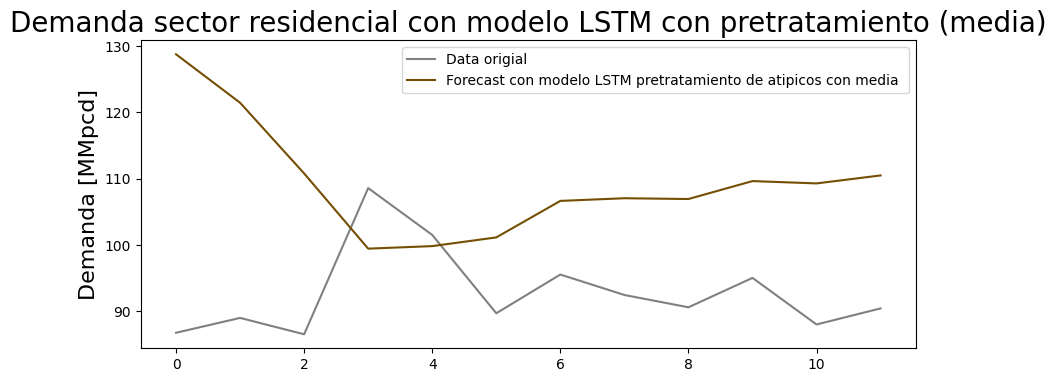

In [178]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_media , color='#744E03')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM pretratamiento de atipicos con media '))

plt.title('Demanda sector residencial con modelo LSTM con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [179]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_residencial_pretratamiento_media = mean_absolute_percentage_error(demanda_residencial_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_residencial_pretratamiento_media)
RMSE_test_predictions_model_LSTM_residencial_pretratamiento_media = np.sqrt(mean_squared_error(demanda_residencial_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_residencial_pretratamiento_media))

print('MAPE:', MAPE_test_predictions_model_LSTM_residencial_pretratamiento_media)
print('RMSE:', RMSE_test_predictions_model_LSTM_residencial_pretratamiento_media)

MAPE: 0.2022054596312558
RMSE: 20.98989516574897


Se muestra la comparación del forecast de demanda residencial con modelo LSTM entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

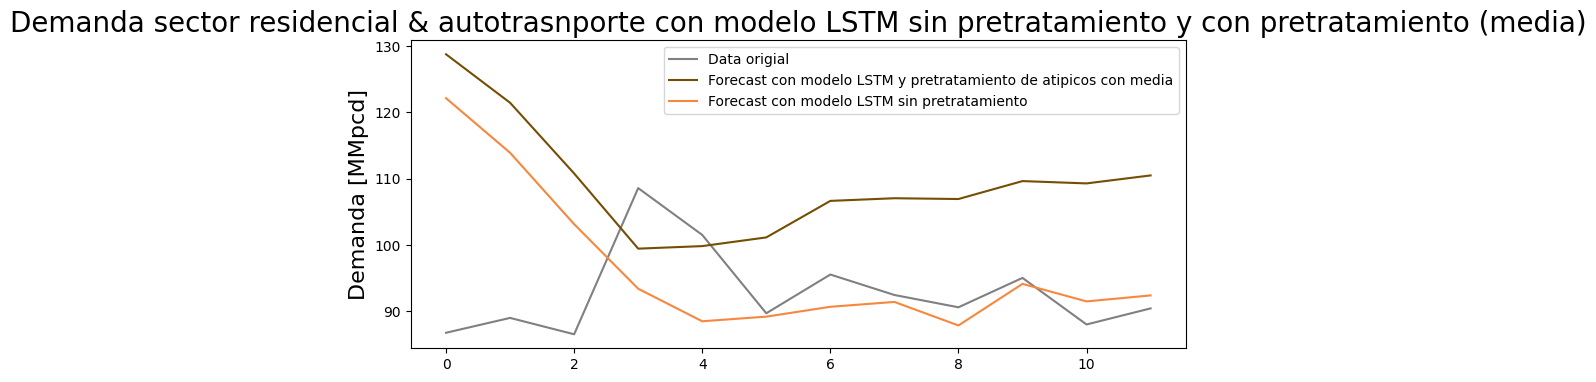

In [180]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_media , color='#744E03')
plt.plot(test_predictions_model_LSTM_residencial_original, color='#F8873E')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda sector residencial & autotrasnporte con modelo LSTM sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Proceso para decidir el modelo ARIMA a aplicar en el caso de (pretratamiento de atípicos por la media)


Se verifica la estacionariedad de la data (pretratamiento de atípicos por la media) con ayuda de la prueba de Dickey-Fuller

In [181]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_residencial_pretratamiento_media_sin_diferenciar = adfuller(demanda_residencial_train_pretratamiento_media)

adf_test_residencial_pretratamiento_media_sin_diferenciar

(-1.3362462534806216,
 0.6124308537096074,
 12,
 200,
 {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
 1693.6306209951667)

In [182]:
print(f"The ADF statistic value f is: {adf_test_residencial_pretratamiento_media_sin_diferenciar[0]}")

print(f"The ADF p value p is: {adf_test_residencial_pretratamiento_media_sin_diferenciar[1]}")

if adf_test_residencial_pretratamiento_media_sin_diferenciar[0] < adf_test_residencial_pretratamiento_media_sin_diferenciar[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -1.3362462534806216
The ADF p value p is: 0.6124308537096074
Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad


Se procede a hacer la primer diferencia para lograr estacionariedad

In [183]:
demanda_residencial_pretratamiento_media_diff1 = demanda_residencial_train_pretratamiento_media.diff()
demanda_residencial_pretratamiento_media_diff1

Date
2005-01-01       NaN
2005-02-01     7.896
2005-03-01   -45.115
2005-04-01   -17.695
2005-05-01    -7.438
               ...  
2022-05-01    -3.040
2022-06-01    -1.908
2022-07-01     4.390
2022-08-01    -6.918
2022-09-01     2.364
Name: Demanded_Gas, Length: 213, dtype: float64

Se verifica la estacionariedad de la data DIFERENCIA1 (pretratamiento de atípicos por la media) con ayuda de la prueba de Dickey-Fulley

In [184]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_residencial_pretratamiento_media_diff1 = adfuller(demanda_residencial_pretratamiento_media_diff1.dropna())

adf_test_residencial_pretratamiento_media_diff1

(-7.828927341728951,
 6.369941458486206e-12,
 11,
 200,
 {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
 1685.9104460778149)

In [185]:
print(f"The ADF statistic value f is: {adf_test_residencial_pretratamiento_media_diff1[0]}")

print(f"The ADF p value p is: {adf_test_residencial_pretratamiento_media_diff1[1]}")

if adf_test_residencial_pretratamiento_media_diff1[0] < adf_test_residencial_pretratamiento_media_diff1[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -7.828927341728951
The ADF p value p is: 6.369941458486206e-12
Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad


Se realizan las gráficas ACF & PACF para determinar el tipo de modelo ARIMA a implementar

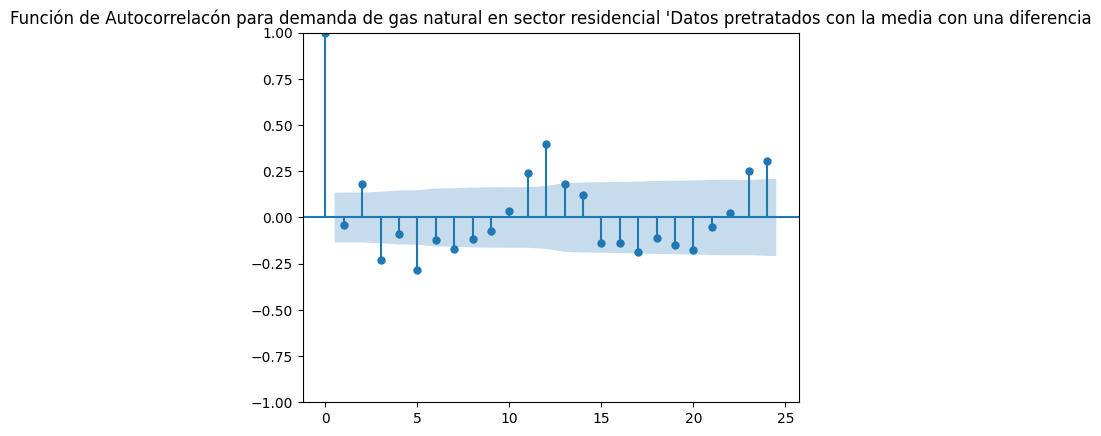

In [186]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_acf(demanda_residencial_pretratamiento_media_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón para demanda de gas natural en sector residencial 'Datos pretratados con la media con una diferencia")

# Show the plot
plt.show()

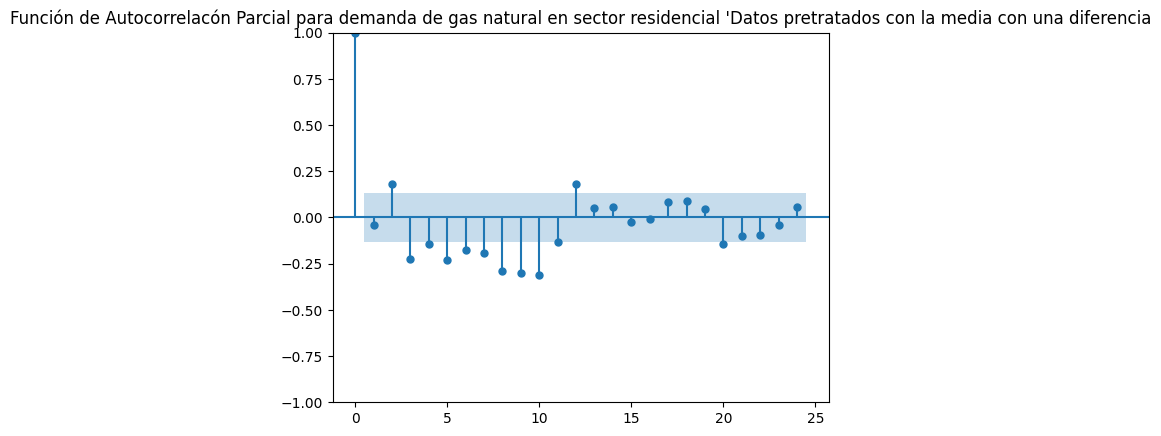

In [187]:

import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_pacf(demanda_residencial_pretratamiento_media_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón Parcial para demanda de gas natural en sector residencial 'Datos pretratados con la media con una diferencia")

# Show the plot
plt.show()

Apliquemos un modelo ARIMA a nuestra data de Demanda de gas natural en sector residencial 'Datos atipicos con tratamiento media'

In [188]:
##Create the model
model_ARIMA_residencial_tratamiento_media = ARIMA (demanda_residencial_train_pretratamiento_media, order=(4,1,3))

##Fit the model
start = time()
model_ARIMA_residencial_tratamiento_media_fit = model_ARIMA_residencial_tratamiento_media.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_residencial_tratamiento_media_fit.summary())

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\sta

Model fitting time 6.220936298370361
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -916.594
Date:                Wed, 19 Jun 2024   AIC                           1849.187
Time:                        10:33:51   BIC                           1876.040
Sample:                    01-01-2005   HQIC                          1860.040
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3455      0.060      5.792      0.000       0.229       0.462
ar.L2          0.9855      0.054     18.317      0.000       0.880       1.091
ar.L3         -

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [189]:
##get prediction start and end dates 
pred_model_ARIMA_residencial_start_date = demanda_residencial_original_test_data.index[0]
pred_model_ARIMA_residencial_end_date = demanda_residencial_original_test_data.index[-1]

In [190]:
##get the predictors and residuals 
predictions_model_ARIMA_residencial_tratamiento_media = model_ARIMA_residencial_tratamiento_media_fit.predict(start=pred_model_ARIMA_residencial_start_date, end= pred_model_ARIMA_residencial_end_date)
print(predictions_model_ARIMA_residencial_tratamiento_media)

2022-10-01     93.743918
2022-11-01     96.331425
2022-12-01    101.115842
2023-01-01    101.495435
2023-02-01    103.053533
2023-03-01     99.717166
2023-04-01     98.193033
2023-05-01     93.153590
2023-06-01     91.720565
2023-07-01     88.473838
2023-08-01     90.003274
2023-09-01     90.066606
Freq: MS, Name: predicted_mean, dtype: float64


In [191]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_residencial_tratamiento_media = mean_absolute_percentage_error(demanda_residencial_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_residencial_tratamiento_media)
RMSE_predictions_model_ARIMA_residencial_tratamiento_media= np.sqrt(mean_squared_error(demanda_residencial_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_residencial_tratamiento_media))

print('MAPE:', MAPE_predictions_model_ARIMA_residencial_tratamiento_media)
print('RMSE:', RMSE_predictions_model_ARIMA_residencial_tratamiento_media)

MAPE: 0.055391034055667865
RMSE: 6.595168645549333


Text(0, 0.5, 'Demanda [MMpcd]')

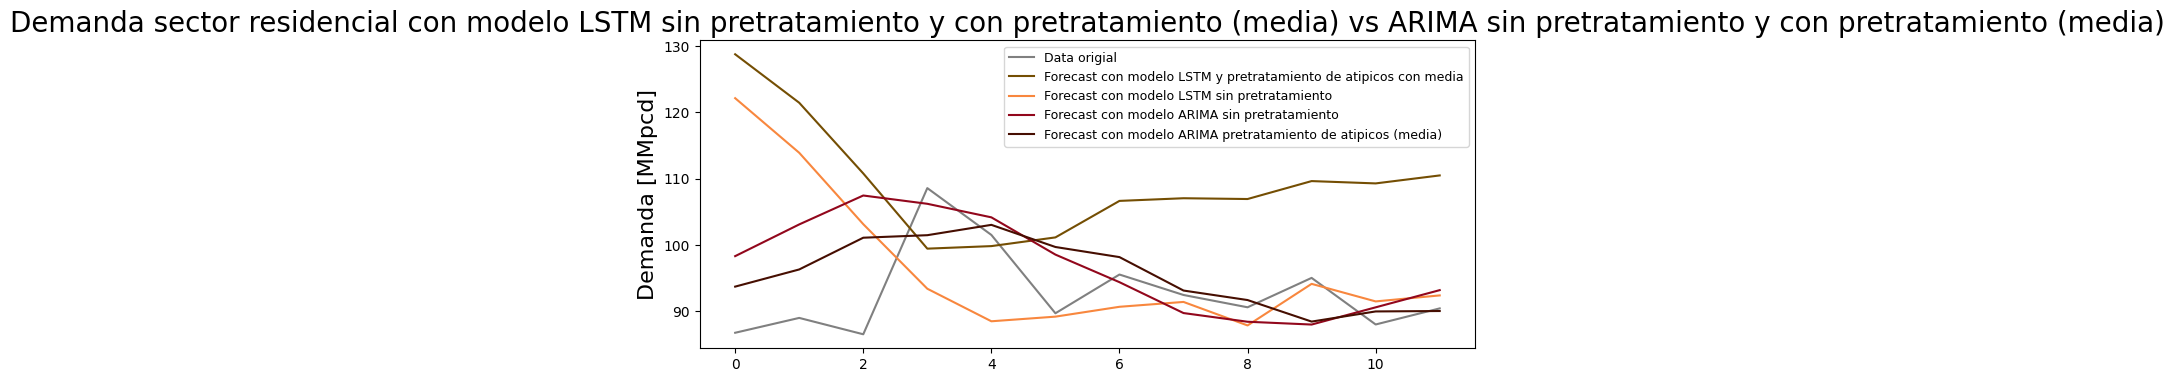

In [192]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))


plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_media , color='#744E03')
plt.plot(test_predictions_model_LSTM_residencial_original, color='#F8873E')

plt.plot(predictions_model_ARIMA_residencial_original.values, color='#92071C')

plt.plot(predictions_model_ARIMA_residencial_tratamiento_media.values,color='#460E01')

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento', 'Forecast con modelo ARIMA sin pretratamiento ', 'Forecast con modelo ARIMA pretratamiento de atipicos (media)' ), fontsize=9)

plt.title('Demanda sector residencial con modelo LSTM sin pretratamiento y con pretratamiento (media) vs ARIMA sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [193]:
MAPE_predictions_model_ARIMA_residencial_tratamiento_media: 0.13994500811231925
RMSE_predictions_model_ARIMA_residencial_tratamiento_media: 655.5176263602883
MAPE_predictions_model_LSTM_residencial_pretratamiento_media: 0.1138521851839455
RMSE_predictions_model_LSTM_residencial_pretratamiento_media: 582.2575418499564

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [194]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [195]:
demanda_residencial_original_train_para_tratamiento2 = demanda_residencial_original_train_data.copy()
demanda_residencial_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,152.096
2005-02-01,159.992
2005-03-01,114.877
2005-04-01,97.182
2005-05-01,89.744
...,...
2022-05-01,91.528
2022-06-01,89.620
2022-07-01,94.010


In [196]:
demanda_residencial_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_residencial_original_train_para_tratamiento2['Demanded_Gas'])
demanda_residencial_train_pretratamiento_mediana

Date
2005-01-01    152.096
2005-02-01    159.992
2005-03-01    114.877
2005-04-01     97.182
2005-05-01     89.744
               ...   
2022-05-01     91.528
2022-06-01     89.620
2022-07-01     94.010
2022-08-01     87.092
2022-09-01     89.456
Name: Demanded_Gas, Length: 213, dtype: float64

Text(0, 0.5, 'Demand [mmscfd]')

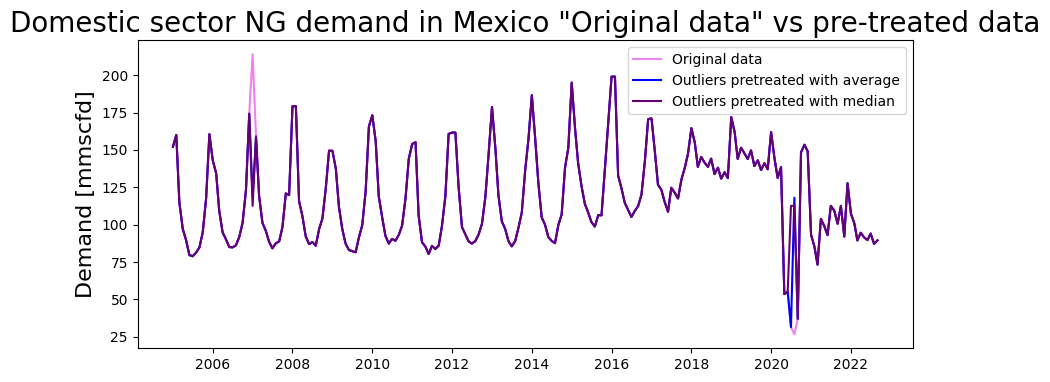

In [197]:
plt.figure(figsize=(10,4))

plt.plot(demanda_residencial_original_train_data, color='violet')
plt.plot(demanda_residencial_train_pretratamiento_media,color='blue')

plt.plot(demanda_residencial_train_pretratamiento_mediana, color= '#660374')


plt.legend(('Original data', 'Outliers pretreated with average', 'Outliers pretreated with median'))
plt.title('Domestic sector NG demand in Mexico "Original data" vs pre-treated data', fontsize=20)
plt.ylabel('Demand [mmscfd]', fontsize =16)

Se descompone la data con pretratamiento de mediana de Demanda en sector residencial en sus componentes de Tendencia, Estacionalidad y Residual

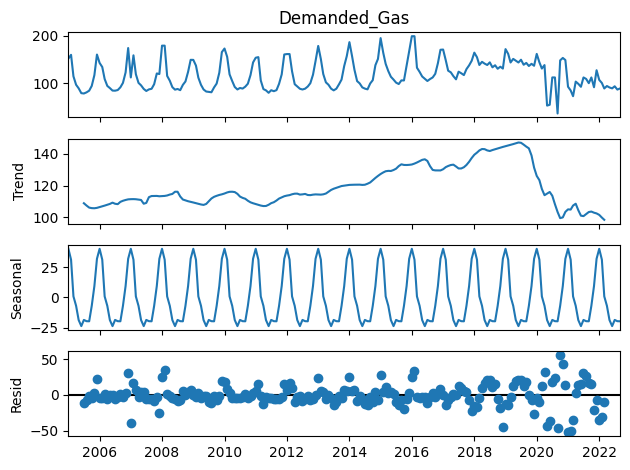

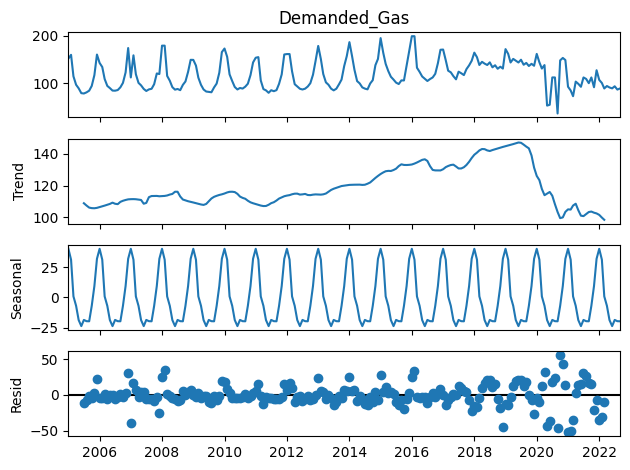

In [198]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_residencial_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_residencial_train_pretratamiento_mediana)
demanda_residencial_train_pretratamiento_mediana_seasonal_decomposition.plot()


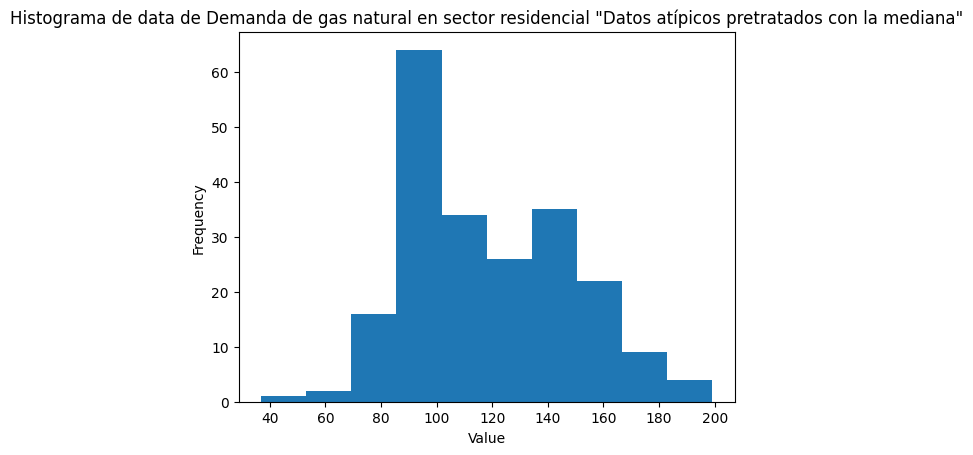

In [199]:
# Generate the histogram
plt.hist(demanda_residencial_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector residencial "Datos atípicos pretratados con la mediana"')
# Display the plot
plt.show()

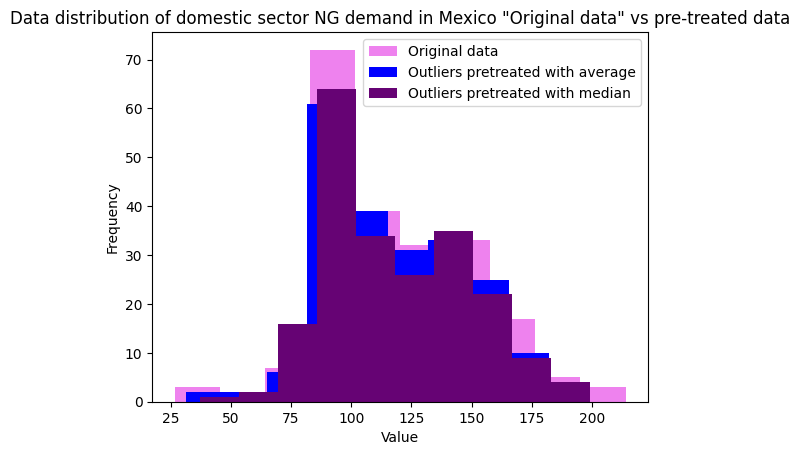

In [200]:
# Generate the histogram

plt.hist(demanda_residencial_original_train_data, bins=10, color= 'violet')

plt.hist(demanda_residencial_train_pretratamiento_media, bins=10, color= 'blue')  # Adjust the number of bins as per your data

plt.hist(demanda_residencial_train_pretratamiento_mediana, bins=10, color= '#660374')  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Data distribution of domestic sector NG demand in Mexico "Original data" vs pre-treated data')
plt.legend(('Original data', 'Outliers pretreated with average', 'Outliers pretreated with median'))
# Display the plot
plt.show()

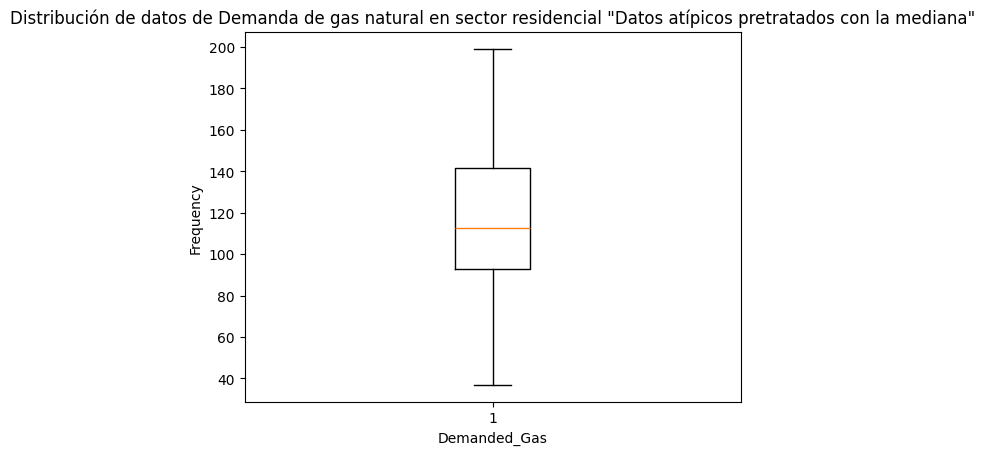

In [201]:
# Create a boxplot of the Demanded_Gas column

plt.boxplot(demanda_residencial_train_pretratamiento_mediana)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector residencial "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

In [202]:
demanda_residencial_train_pretratamiento_mediana.describe()

count    213.000000
mean     118.293075
std       29.954287
min       36.939000
25%       92.949000
50%      112.557000
75%      141.576000
max      199.052000
Name: Demanded_Gas, dtype: float64

Evaluación de la dispersión de los datos mediante el cociente de media / desviación estandar

In [203]:
mean_demanda_residencial_train_pretratamiento_mediana = demanda_residencial_train_pretratamiento_mediana.describe().values[1]
mean_demanda_residencial_train_pretratamiento_mediana

118.2930751173709

In [204]:
std_demanda_residencial_train_pretratamiento_mediana = demanda_residencial_train_pretratamiento_mediana.describe().values[2]
std_demanda_residencial_train_pretratamiento_mediana

29.95428722668062

In [205]:
mean_demanda_residencial_train_pretratamiento_mediana / std_demanda_residencial_train_pretratamiento_mediana

3.9491200115089344

Recordando el valor del cociente para el caso de no tratamiento de atípicos y de tratamiento con la media

In [206]:
mean_demanda_residencial_original_train_data / st_demanda_residencial_original_train_data

array([3.70304753])

In [207]:
mean_demanda_residencial_train_pretratamiento_media / std_demanda_residencial_train_pretratamiento_media

3.863400313239775

In [208]:
import scipy.stats as stats

# Assuming demanda_residencial_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_residencial_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 7.625951106934096
p-value: 0.0220823738182601


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [209]:
n_input = n_input 

data = demanda_residencial_train_pretratamiento_mediana
targets = data 

demanda_residencial_train_generator_pretratamiento_mediana = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_residencial_train_generator_pretratamiento_mediana[0]

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[152.096, 159.992, 114.877,  97.182,  89.744,  79.576,  78.868,
          81.248,  84.803,  94.76 , 117.495, 160.554, 142.983, 134.402,
         109.338,  94.816,  90.252,  84.982,  84.755,  86.098,  91.856,
         101.146, 123.065, 174.222]]),
 array([112.557]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [210]:
print("Total number of samples in the original training data = ", len(demanda_residencial_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_residencial_scaled_train_generator = ", len(demanda_residencial_train_generator_pretratamiento_mediana))

Total number of samples in the original training data =  213
Total number of samples in the demanda_residencial_scaled_train_generator =  189


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector residencial con pretratamiento de mediana 

In [211]:
n_input = n_input
n_features = n_features

# define model
model_LSTM_residencial_pretrataminto_mediana = Sequential()

model_LSTM_residencial_pretrataminto_mediana.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_residencial_pretrataminto_mediana.add(Dense(1))
model_LSTM_residencial_pretrataminto_mediana.compile(optimizer='adam', loss='mse')

model_LSTM_residencial_pretrataminto_mediana.summary()

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

Se entrena el modelo 

In [212]:
model_LSTM_residencial_pretrataminto_mediana.fit(demanda_residencial_train_generator_pretratamiento_mediana, epochs=15)

Epoch 1/15
 33/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8306.3828

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5034.5981
Epoch 2/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1011.5750
Epoch 3/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 69505.7891
Epoch 4/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 894.5463
Epoch 5/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 716.7914
Epoch 6/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 849.6492
Epoch 7/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 868.3761
Epoch 8/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1292.4288
Epoch 9/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 863.0927
Epoch 10/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 652.8640
Epoch 11/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 708.7280
Epoch 12/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 925.0937
Epoch 13/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1041.2692
Epoch 14/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 787.5187
Epoch 15/15
189/189 ━━━━━━━━━━━━━━

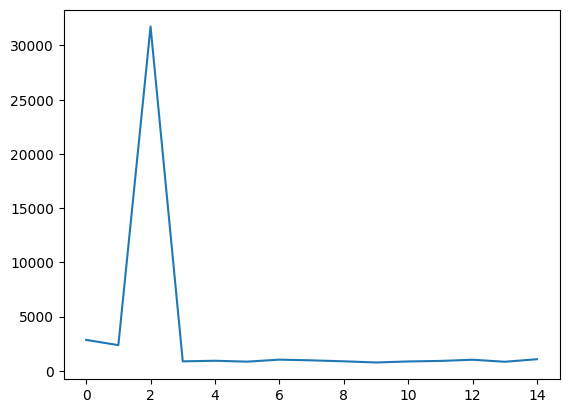

In [213]:
loss_per_epoch = model_LSTM_residencial_pretrataminto_mediana.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [214]:
demanda_residencial_train_pretratamiento_mediana

Date
2005-01-01    152.096
2005-02-01    159.992
2005-03-01    114.877
2005-04-01     97.182
2005-05-01     89.744
               ...   
2022-05-01     91.528
2022-06-01     89.620
2022-07-01     94.010
2022-08-01     87.092
2022-09-01     89.456
Name: Demanded_Gas, Length: 213, dtype: float64

In [215]:
demanda_residencial_train_batch_pretratamiento_mediana = demanda_residencial_train_pretratamiento_mediana[-n_input:]


demanda_residencial_train_batch_pretratamiento_mediana

Date
2020-10-01    148.324
2020-11-01    153.468
2020-12-01    149.084
2021-01-01     93.077
2021-02-01     85.229
2021-03-01     73.218
2021-04-01    103.831
2021-05-01     99.209
2021-06-01     92.949
2021-07-01    112.564
2021-08-01    109.434
2021-09-01    100.533
2021-10-01    112.531
2021-11-01     91.981
2021-12-01    127.691
2022-01-01    107.384
2022-02-01    100.933
2022-03-01     89.417
2022-04-01     94.568
2022-05-01     91.528
2022-06-01     89.620
2022-07-01     94.010
2022-08-01     87.092
2022-09-01     89.456
Name: Demanded_Gas, dtype: float64

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [216]:
demanda_residencial_train_batch_pretratamiento_mediana_reshaped = demanda_residencial_train_batch_pretratamiento_mediana.values.reshape(1,n_input, n_features)
demanda_residencial_train_batch_pretratamiento_mediana_reshaped

array([[[148.324],
        [153.468],
        [149.084],
        [ 93.077],
        [ 85.229],
        [ 73.218],
        [103.831],
        [ 99.209],
        [ 92.949],
        [112.564],
        [109.434],
        [100.533],
        [112.531],
        [ 91.981],
        [127.691],
        [107.384],
        [100.933],
        [ 89.417],
        [ 94.568],
        [ 91.528],
        [ 89.62 ],
        [ 94.01 ],
        [ 87.092],
        [ 89.456]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [217]:
model_LSTM_residencial_pretrataminto_mediana.predict(demanda_residencial_train_batch_pretratamiento_mediana_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


array([[87.24041]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [218]:
n_input = n_input
n_features = n_features

In [219]:
test_predictions_model_LSTM_residencial_pretratamiento_mediana  = []

first_eval_batch = demanda_residencial_train_pretratamiento_mediana[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_residencial_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_residencial_pretrataminto_mediana.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_residencial_pretratamiento_mediana.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [220]:
test_predictions_model_LSTM_residencial_pretratamiento_mediana

[array([87.24041], dtype=float32),
 array([83.29474], dtype=float32),
 array([69.761246], dtype=float32),
 array([61.517902], dtype=float32),
 array([59.234592], dtype=float32),
 array([57.310154], dtype=float32),
 array([64.457596], dtype=float32),
 array([62.05042], dtype=float32),
 array([60.59138], dtype=float32),
 array([60.957027], dtype=float32),
 array([58.00764], dtype=float32),
 array([58.908134], dtype=float32)]

Text(0, 0.5, 'Demanda [MMpcd]')

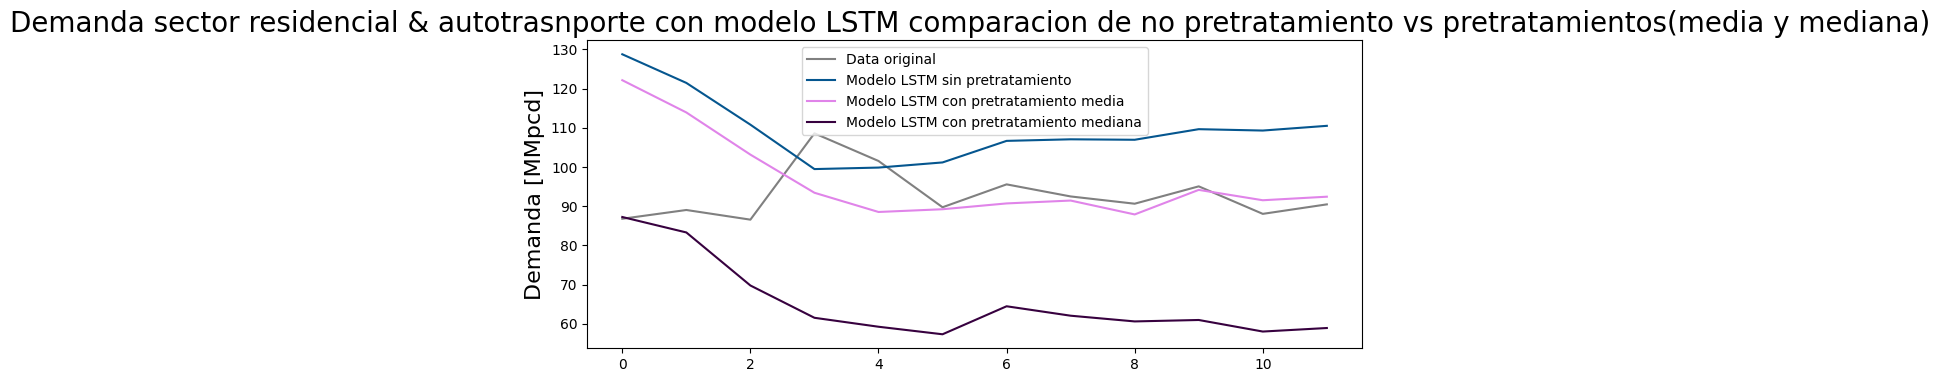

In [221]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')

plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_media , color='#05568F')
plt.plot(test_predictions_model_LSTM_residencial_original, color='#E084E9')
plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_mediana, color='#37013F' )


plt.legend(('Data original', 'Modelo LSTM sin pretratamiento', 'Modelo LSTM con pretratamiento media', 'Modelo LSTM con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector residencial & autotrasnporte con modelo LSTM comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [222]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_residencial_pretratamiento_mediana = mean_absolute_percentage_error(demanda_residencial_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_residencial_pretratamiento_mediana)
RMSE_test_predictions_model_LSTM_residencial_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_residencial_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_residencial_pretratamiento_mediana))

print('MAPE:', MAPE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)

MAPE: 0.29248050093648664
RMSE: 30.589079586080665



Proceso para decidir el modelo ARIMA a aplicar en el caso de (pretratamiento de atípicos por la mediana)


Se verifica la estacionariedad de la data (pretratamiento de atípicos por la mediana) con ayuda de la prueba de Dickey-Fuller

In [223]:

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_residencial_pretratamiento_mediana_sin_diferenciar = adfuller(demanda_residencial_train_pretratamiento_mediana)

adf_test_residencial_pretratamiento_mediana_sin_diferenciar

(-1.3229106401799706,
 0.6186265852209747,
 14,
 198,
 {'1%': -3.4638151713286316,
  '5%': -2.876250632135043,
  '10%': -2.574611347821651},
 1687.8842788290187)

In [224]:
print(f"The ADF statistic value f is: {adf_test_residencial_pretratamiento_mediana_sin_diferenciar[0]}")

print(f"The ADF p value p is: {adf_test_residencial_pretratamiento_mediana_sin_diferenciar[1]}")

if adf_test_residencial_pretratamiento_mediana_sin_diferenciar[0] < adf_test_residencial_pretratamiento_mediana_sin_diferenciar[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -1.3229106401799706
The ADF p value p is: 0.6186265852209747
Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad



Se procede a hacer la primer diferencia para lograr estacionariedad

In [225]:
demanda_residencial_pretratamiento_mediana_diff1 = demanda_residencial_train_pretratamiento_mediana.diff()
demanda_residencial_pretratamiento_mediana_diff1

Date
2005-01-01       NaN
2005-02-01     7.896
2005-03-01   -45.115
2005-04-01   -17.695
2005-05-01    -7.438
               ...  
2022-05-01    -3.040
2022-06-01    -1.908
2022-07-01     4.390
2022-08-01    -6.918
2022-09-01     2.364
Name: Demanded_Gas, Length: 213, dtype: float64


Se verifica la estacionariedad de la data DIFERENCIA1 (pretratamiento de atípicos por la mediana) con ayuda de la prueba de Dickey-Fuller

In [226]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_residencial_pretratamiento_mediana_diff1 = adfuller(demanda_residencial_pretratamiento_mediana_diff1.dropna())

adf_test_residencial_pretratamiento_mediana_diff1

(-12.977807922982311,
 2.98709363462701e-24,
 10,
 201,
 {'1%': -3.4633090972761744,
  '5%': -2.876029332045744,
  '10%': -2.5744932593252643},
 1679.6114025345382)

In [227]:
print(f"The ADF statistic value f is: {adf_test_residencial_pretratamiento_mediana_diff1[0]}")

print(f"The ADF p value p is: {adf_test_residencial_pretratamiento_mediana_diff1[1]}")

if adf_test_residencial_pretratamiento_mediana_diff1[0] < adf_test_residencial_pretratamiento_mediana_diff1[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -12.977807922982311
The ADF p value p is: 2.98709363462701e-24
Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad



Se realizan las gráficas ACF & PACF para determinar el tipo de modelo ARIMA a implementar

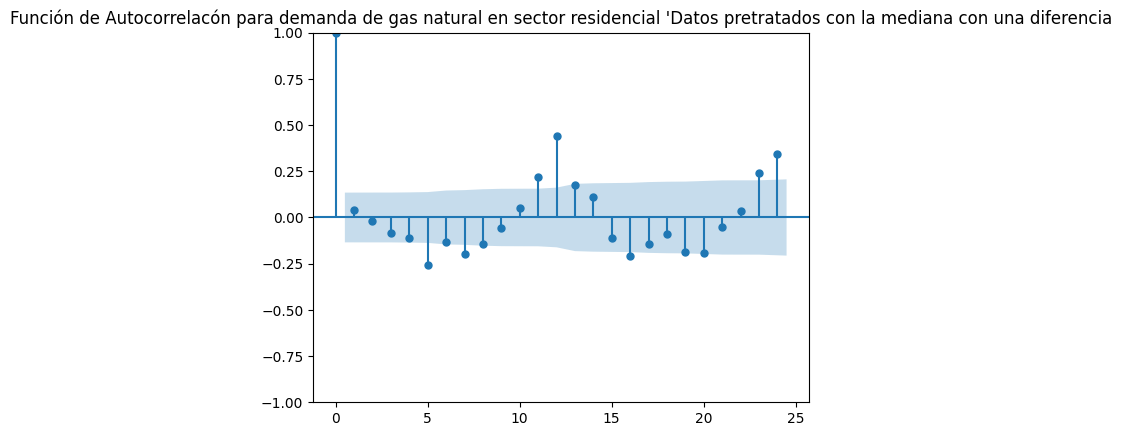

In [228]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_acf(demanda_residencial_pretratamiento_mediana_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón para demanda de gas natural en sector residencial 'Datos pretratados con la mediana con una diferencia")

# Show the plot
plt.show()

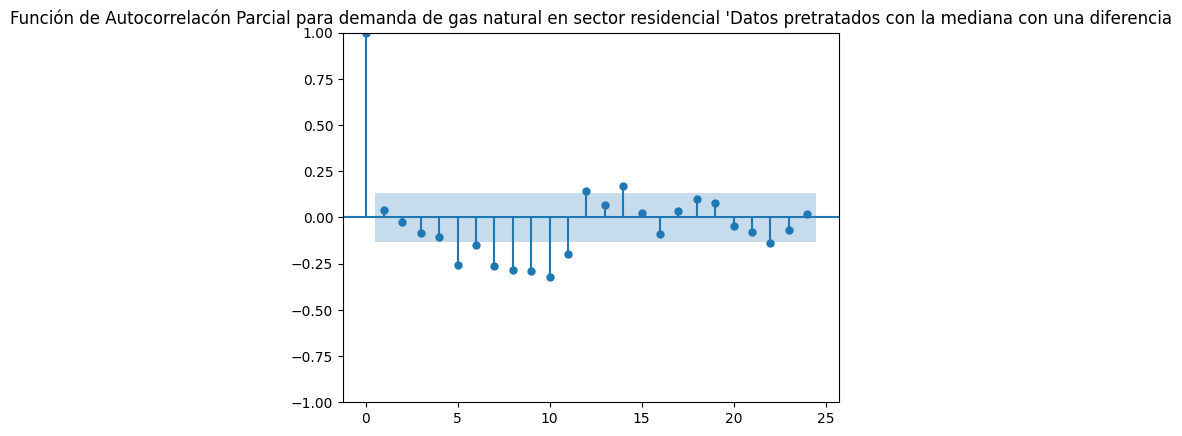

In [229]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_pacf(demanda_residencial_pretratamiento_mediana_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón Parcial para demanda de gas natural en sector residencial 'Datos pretratados con la mediana con una diferencia")

# Show the plot
plt.show()

Modelo ARIMA para el caso del pretratamiento de datos con la mediana 

In [230]:
##Create the model
model_ARIMA_residencial_tratamiento_mediana = ARIMA (demanda_residencial_train_pretratamiento_mediana, order=(3,1,3))

##Fit the model
start = time()
model_ARIMA_residencial_tratamiento_mediana_fit = model_ARIMA_residencial_tratamiento_mediana.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_residencial_tratamiento_mediana_fit.summary())

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\sta

Model fitting time 6.4394800662994385
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -919.465
Date:                Wed, 19 Jun 2024   AIC                           1852.929
Time:                        10:34:26   BIC                           1876.426
Sample:                    01-01-2005   HQIC                          1862.426
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6992      0.156      4.483      0.000       0.393       1.005
ar.L2          0.5929      0.259      2.290      0.022       0.085       1.100
ar.L3         

In [231]:
##get prediction start and end dates 
pred_model_ARIMA_residencial_start_date = demanda_residencial_original_test_data.index[0]
pred_model_ARIMA_residencial_end_date = demanda_residencial_original_test_data.index[-1]

In [232]:
##get the predictors and residuals 
predictions_model_ARIMA_residencial_tratamiento_mediana = model_ARIMA_residencial_tratamiento_mediana_fit.predict(start=pred_model_ARIMA_residencial_start_date, end= pred_model_ARIMA_residencial_end_date)
print(predictions_model_ARIMA_residencial_tratamiento_mediana)

2022-10-01    101.569430
2022-11-01    107.988957
2022-12-01    112.172614
2023-01-01    109.625808
2023-02-01    105.408677
2023-03-01     97.745745
2023-04-01     91.838315
2023-05-01     86.394655
2023-06-01     84.955331
2023-07-01     85.246146
2023-08-01     88.765581
2023-09-01     92.501156
Freq: MS, Name: predicted_mean, dtype: float64


In [233]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana = mean_absolute_percentage_error(demanda_residencial_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_residencial_tratamiento_mediana)
RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana= np.sqrt(mean_squared_error(demanda_residencial_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_residencial_tratamiento_mediana))

print('MAPE:', MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana)
print('RMSE:', RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana)

MAPE: 0.09313972978510993
RMSE: 11.174568450032314


Text(0, 0.5, 'Demanda [MMpcd]')

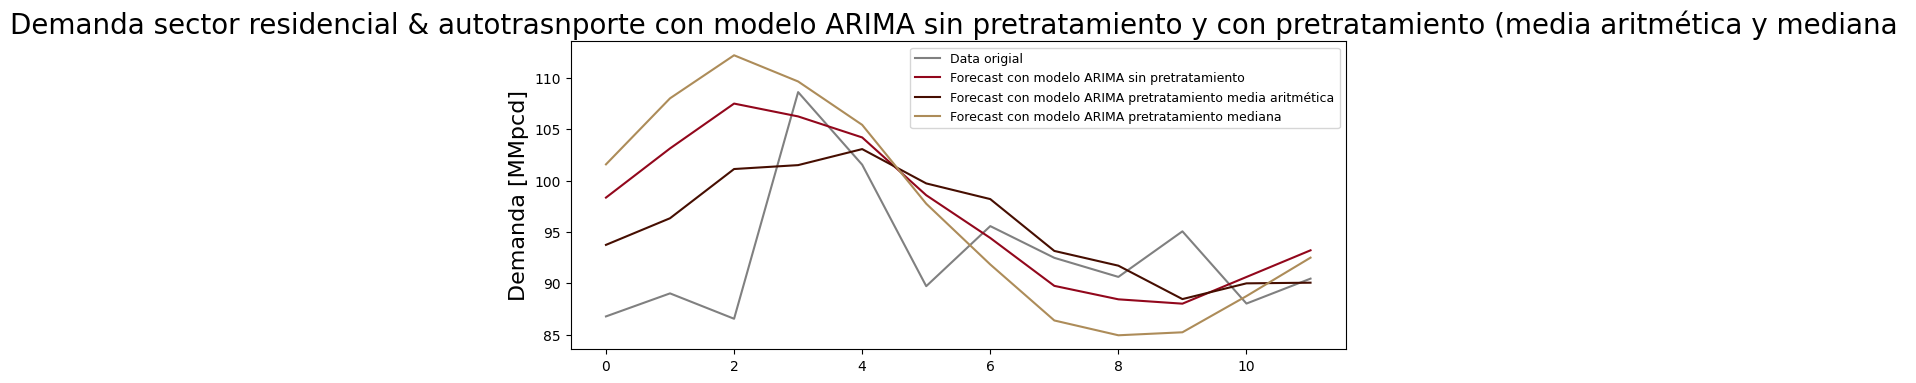

In [234]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')


plt.plot(predictions_model_ARIMA_residencial_original.values, color='#92071C')
plt.plot(predictions_model_ARIMA_residencial_tratamiento_media.values,color='#460E01')

plt.plot(predictions_model_ARIMA_residencial_tratamiento_mediana.values, color='#AD8C59')



plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial','Forecast con modelo ARIMA sin pretratamiento','Forecast con modelo ARIMA pretratamiento media aritmética', 'Forecast con modelo ARIMA pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector residencial & autotrasnporte con modelo ARIMA sin pretratamiento y con pretratamiento (media aritmética y mediana ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Text(0, 0.5, 'Demand [mmscfd]')

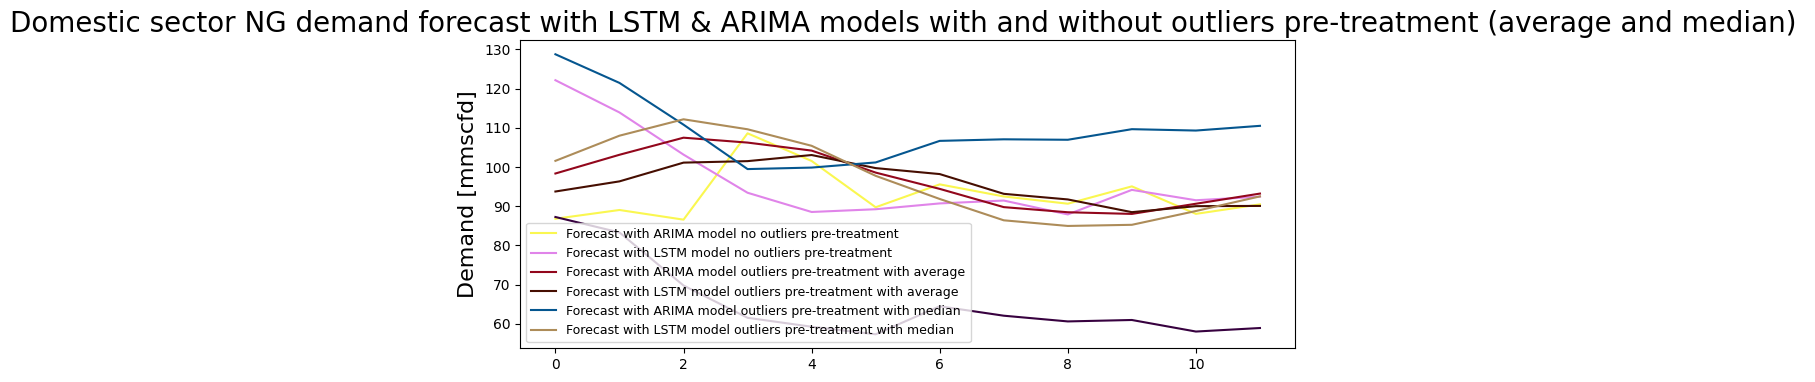

In [235]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='#FAF750')


plt.plot(test_predictions_model_LSTM_residencial_original, color='#E084E9')
plt.plot(predictions_model_ARIMA_residencial_original.values, color='#92071C')

plt.plot(predictions_model_ARIMA_residencial_tratamiento_media.values,color='#460E01')
plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_media , color='#05568F')


plt.plot(predictions_model_ARIMA_residencial_tratamiento_mediana.values, color='#AD8C59')
plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_mediana, color='#37013F' )


plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Forecast with ARIMA model no outliers pre-treatment', 'Forecast with LSTM model no outliers pre-treatment', 'Forecast with ARIMA model outliers pre-treatment with average' , 'Forecast with LSTM model outliers pre-treatment with average', 'Forecast with ARIMA model outliers pre-treatment with median' , 'Forecast with LSTM model outliers pre-treatment with median'), fontsize=9)

plt.title('Domestic sector NG demand forecast with LSTM & ARIMA models with and without outliers pre-treatment (average and median) ', fontsize=20)
plt.ylabel('Demand [mmscfd]', fontsize=16)

Resumen de errores RMSE & MAPE de los modelos ARIMA & LSTM + pretratamiento de atípicos con la mediana

In [137]:
print('MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana:', MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana)
print('RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana:', RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana)


print('MAPE_predictions_model_LSTM_residencial_pretratamiento_mediana:', MAPE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)
print('RMSE_predictions_model_LSTM_residencial_pretratamiento_mediana:', RMSE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)

MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana: 0.09313972978510993
RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana: 11.174568450032314
MAPE_predictions_model_LSTM_residencial_pretratamiento_mediana: 0.21047080968075393
RMSE_predictions_model_LSTM_residencial_pretratamiento_mediana: 22.57876569993406


Resumen de errores RMSE & MAPE de los modelos ARIMA & LSTM

In [140]:
print('MAPE_predictions_model_LSTM_residencial_original:', MAPE_predictions_model_LSTM_residencial_original)
print('RMSE_predictions_model_LSTM_residencial_original:', RMSE_predictions_model_LSTM_residencial_original)


print('MAPE_predictions_model_ARIMA_residencial_original:', MAPE_predictions_model_ARIMA_residencial_original)
print('RMSE_predictions_model_ARIMA_residencial_original:', RMSE_predictions_model_ARIMA_residencial_original)


print('MAPE_predictions_model_ARIMA_residencial_tratamiento_media:', MAPE_predictions_model_ARIMA_residencial_tratamiento_media)
print('RMSE_predictions_model_ARIMA_residencial_tratamiento_media:', RMSE_predictions_model_ARIMA_residencial_tratamiento_media)

print('MAPE_predictions_model_LSTM_residencial_pretratamiento_media:', MAPE_test_predictions_model_LSTM_residencial_pretratamiento_media)
print('RMSE_predictions_model_LSTM_residencial_pretratamiento_media:', RMSE_test_predictions_model_LSTM_residencial_pretratamiento_media)



print('MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana:', MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana)
print('RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana:', RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana)

print('MAPE_predictions_model_LSTM_residencial_pretratamiento_mediana:', MAPE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)
print('RMSE_predictions_model_LSTM_residencial_pretratamiento_mediana:', RMSE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)

MAPE_predictions_model_LSTM_residencial_original: 0.10965740686369334
RMSE_predictions_model_LSTM_residencial_original: 11.792794824993862
MAPE_predictions_model_ARIMA_residencial_original: 0.07322972494549211
RMSE_predictions_model_ARIMA_residencial_original: 8.83876552850229
MAPE_predictions_model_ARIMA_residencial_tratamiento_media: 0.055391034055667865
RMSE_predictions_model_ARIMA_residencial_tratamiento_media: 6.595168645549333
MAPE_predictions_model_LSTM_residencial_pretratamiento_media: 0.07139157996850107
RMSE_predictions_model_LSTM_residencial_pretratamiento_media: 8.7761209812788
MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana: 0.09313972978510993
RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana: 11.174568450032314
MAPE_predictions_model_LSTM_residencial_pretratamiento_mediana: 0.21047080968075393
RMSE_predictions_model_LSTM_residencial_pretratamiento_mediana: 22.57876569993406
